# Название проекта: Аналитический кейс крупного Интернет-магазина

**Описание исследования.**

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Цель исследования.**

Определить гипотезу для увеличения выручки интернет-магазина. Принять решение по результатам А/В теста:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.    

**Задачи исследования.**

- выгрузить датасеты и изучить по ними общую информацию;
- проверить на наличие пропущенных значений и дубликатов;
- приоритизировать гипотезы;
- проанализировать A/B-тест;
- сделать выводы и рекомендации.

**Исходные данные.**

В нашем распоряжении три датасета:
 - **hypothesis.csv** хранит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort,
 - **orders.csv** и **visitors.csv** файлы с результатами проведенного A/B-теста.
 
Структура **hypothesis.csv:**

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура **orders.csv:**

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Структура **visitors.csv:**

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Данное исследование разделим на несколько частей.**

***Часть 1. Изучение общей информации:***

* [1. Изучение файлов с данными, получение общей информации, загрузка библиотек](#1.1-bullet)
* [2. Замена названий столбцов](#1.2-bullet)
* [3. Исследование аномалий](#1.3-bullet)

***Часть 2. Приоритизация гипотез:***

* [1. Фреймворк ICE для приоритизации гипотез](#2.1-bullet)
* [2. Фреймворк RICE для приоритизации гипотез](#2.2-bullet)

***Часть 3. Анализ A/B-теста***

* [1. График кумулятивной выручки по группам](#3.1-bullet)
* [2. График кумулятивного среднего чека по группам](#3.2-bullet)
* [3. График относительного изменения кумулятивного среднего чека группы B к группе A](#3.3-bullet)
* [4. График кумулятивного среднего количества заказов на посетителя по группам](#3.4-bullet)
* [5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A](#3.5-bullet)
* [6. Точечный график количества заказов по пользователям](#3.6-bullet)
* [7. Выбор границы для определения аномальных пользователей](#3.7-bullet)
* [8. Точечный график стоимостей заказов](#3.8-bullet)
* [9. Выбор границы для определения аномальных заказов](#3.9-bullet)
* [10. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным](#3.10-bullet)
* [11. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#3.11-bullet)
* [12. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным](#3.12-bullet)
* [13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#3.13-bullet)
* [14. Решение по результатам теста](#3.14-bullet)

[***ВЫВОД***](#4-bullet)

In [1]:
# импортировали библиотеки Pyhton для проведения исследования
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
from math import factorial
from scipy.stats import binom, norm
pd.options.display.max_colwidth = 120
pd.set_option('display.max_columns', None) # настройка опции для отображения всех столбцов в таблице
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings

## Загрузка данных и подготовка их к анализу

<a id='1.1-bullet'></a>
### Считывание CSV-файлов с данными с помощью библиотеки pandas

In [2]:
# считали файлы из csv-файлов в переменные
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv', parse_dates=['date'])
    visitors = pd.read_csv('visitors.csv', parse_dates=['date'])
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
    visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])

In [3]:
# создали функцию для просмотра и вывода информации датафрейма
def info(df):
    print(df.head(10), '*'*50, sep='\n')
    print(df.info(), '*'*50, sep='\n')
    print(df.duplicated().sum(), '*'*50, sep='\n');

In [4]:
info(hypothesis) # вывели информацию по датасету 'hypothesis.csv'

                                                                                                     Hypothesis  \
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                              Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
7              Добавить форму подписки на все основные страницы, чтобы собрать б

В файле как и заявлено 9 строк и 5 столбцов. В числовых столбцах оценки по 10-балльной шкале. Пропусков и дубликатов нет.

In [5]:
info(orders) # вывели информацию по датасету 'orders.csv'

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     1650     B
1     2804400009  3642806036 2019-08-15      730     B
2     2961555356  4069496402 2019-08-15      400     A
3     3797467345  1196621759 2019-08-15     9759     B
4     2282983706  2322279887 2019-08-15     2308     B
5      182168103   935554773 2019-08-15     2210     B
6      398296753  2900797465 2019-08-15     1860     B
7     2626614568    78758296 2019-08-15     1044     A
8     1576988021   295230930 2019-08-15    13710     A
9     1506739906  1882260405 2019-08-15     1855     B
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null 

Датасет содержит 1197 строк и 5 столбцов. Пропущенных значений и дубликатов нет.

In [6]:
info(visitors) # вывели информацию по датасету 'visitors.csv'

        date group  visitors
0 2019-08-01     A       719
1 2019-08-02     A       619
2 2019-08-03     A       507
3 2019-08-04     A       717
4 2019-08-05     A       756
5 2019-08-06     A       667
6 2019-08-07     A       644
7 2019-08-08     A       610
8 2019-08-09     A       617
9 2019-08-10     A       406
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None
**************************************************
0
**************************************************


Датасет содержит 62 исследования и 3 столбца. Пропущенных значений и дубликатов нет.

В исходных данных нет пропусков и дубликатов. Назавания столбцов не корректно записаны, с большой буквы, нужно заменить для удобства.

<a id='1.2-bullet'></a>
### Замена названий столбцов

Заменим названия столбцов: приведем к нижнему регистру

In [7]:
#изменили названия столбцов в переменной hypothesis
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts'] 

In [8]:
hypothesis.columns #вывели исправленные названия

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [9]:
#изменили названия столбцов в переменной orders
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [10]:
orders.columns #вывели исправленные названия

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Привели названия к змеиному регистру

<a id='1.3-bullet'></a>
### Исследование аномалий

In [11]:
# проверили количество строк в датафрейме orders
before = orders.shape[0]

In [12]:
# проверили количество уникальных заказов
orders['transaction_id'].nunique()

1197

In [13]:
# проверили количество уникальных посетителей
orders['visitor_id'].nunique()

1031

Некоторые посетители делали более одного заказа

In [14]:
# определили максимальную и минимальную дату в датафреймах
print(orders['date'].min().date())
print(visitors['date'].min().date())
print(orders['date'].max().date())
print(visitors['date'].max().date())

2019-08-01
2019-08-01
2019-08-31
2019-08-31


Тест длился с 1 августа 2019 по 31 августа 2019.

In [15]:
print(orders['group'].unique())
print(visitors['group'].unique())

['B' 'A']
['A' 'B']


Проверили, что в обоих датафрейма только группы A и В

In [16]:
print(orders[orders['group'] == 'A']['group'].count())
print(visitors[visitors['group'] == 'A']['group'].count())

557
31


In [17]:
print(orders[orders['group'] == 'B']['group'].count())
print(visitors[visitors['group'] == 'B']['group'].count())

640
31


Сверили количество наблюдений по группам **А** и **В**. В группе **В** на 83 наблюдения больше за 31 день.

In [18]:
(orders['revenue']/1000).describe() # статистика по стоимости заказов

count    1197.000000
mean        8.348006
std        39.191132
min         0.050000
25%         1.220000
50%         2.978000
75%         8.290000
max      1294.500000
Name: revenue, dtype: float64

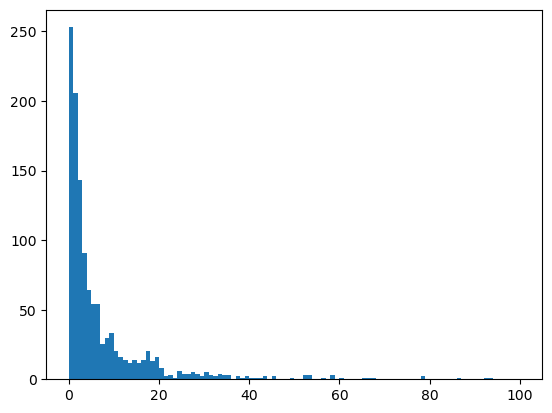

In [19]:
# гистрограмма стоимости заказов
plt.hist(orders['revenue']/1000, bins=100, range=(0, 100));

In [20]:
orders[orders['revenue'] > 8290].sort_values('revenue', ascending=False).head(20)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
662,1811671147,4266935830,2019-08-29,78990,A
682,1216533772,4266935830,2019-08-29,78990,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


Вывели статистику по стоимости заказов. Большинство заказов до 8 тыс.руб. Медианная стоимость заказов 2978 рублей, средняя стоимость заказов 8348 рублей, связана с выбросами: есть заказы на очень крупные суммы, которые повлияли на среднию стоимость.

In [21]:
visitors['visitors'].describe() # статистика по посещениям

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

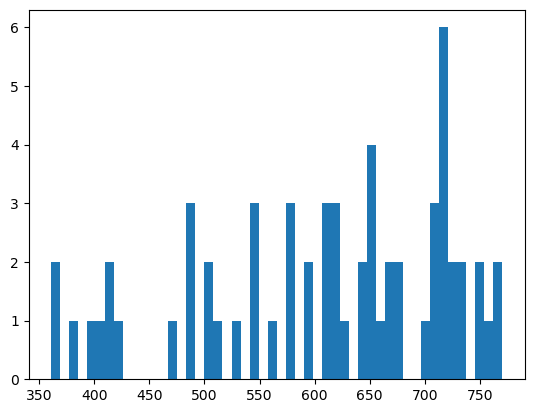

In [22]:
# гистограмма посещений
plt.hist(visitors['visitors'], bins=50);

Вывели статистику по посещениям. Среднее и медиана почти совпадают. Можно сделать вывод что поток клиентов стабильный по дням.

In [23]:
# нашли пользователей, которые участвовали в обоих тестах
orders_u = orders.pivot_table(index='visitor_id', columns='group', values=['transaction_id'], aggfunc=['nunique'])
orders_u = orders_u.reset_index()
orders_u.columns = ['visitor_id', 'A', 'B']
orders_u = orders_u[(~orders_u['A'].isna())&(~orders_u['B'].isna())]
orders_u['visitor_id'].count()

58

In [24]:
orders[orders['visitor_id'].isin(orders_u['visitor_id'])].sort_values('visitor_id')

,transaction_id,visitor_id,date,revenue,group
703,4293855558,8300375,2019-08-07,1790,A
71,3679129301,8300375,2019-08-01,10510,B
823,2971973105,199603092,2019-08-27,2790,A
246,437656952,199603092,2019-08-02,3488,B
26,2223239646,199603092,2019-08-15,3488,A
...,...,...,...,...,...
187,2048878902,4256040402,2019-08-17,1550,A
114,1120327437,4256040402,2019-08-01,5800,A
60,1421016313,4256040402,2019-08-16,56650,B
662,1811671147,4266935830,2019-08-29,78990,A


In [25]:
# для частоты исследования удалим данных пользователей
orders = orders[np.logical_not(orders['visitor_id'].isin(orders_u['visitor_id']))]
after = orders.shape[0]

In [26]:
'Потеряли значений после обработки аномалий - {:.1%}'.format((before-after)/before)

'Потеряли значений после обработки аномалий - 15.1%'

В данном разделе аномалии были выявлены в стоимости заказов, есть заказы на очень крупные суммы, которые могут повлиять на результаты теста. При исследовании необходимо будет их исключить. Также выявили пользователей, которые были в обоих группам и делали заказы, их исключили из иследования, т.к. непонятно, что повлияло на решение сделать заказ.

## Приоритизация гипотез

В файле 'hypothesis.csv' 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Применим один из самых популярных способов приоритизации задач метод ICE и модификацию RICE.

<a id='2.1-bullet'></a>
### Фреймворк ICE для приоритизации гипотез

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [27]:
# посчитали показатель по формуле ICE = (Impact * Confidence) / Effort 
hypothesis['ice'] = (
    hypothesis['impact']
    * hypothesis['confidence']
) / hypothesis['efforts']
hypothesis.sort_values('ice', ascending=False, inplace=True)
hypothesis['ice'] = np.round(hypothesis['ice'], 2)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Наиболее перспективные гипотезы: 
- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

<a id='2.2-bullet'></a>
### Фреймворк RICE для приоритизации гипотез

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [28]:
# посчитали показатель по формуле RICE = (Reach * Impact * Confidence) / Effort
hypothesis['rice'] = (
    hypothesis['reach']
    * hypothesis['impact']
    * hypothesis['confidence']
) / hypothesis['efforts']
hypothesis.sort_values('rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По данному методу самая перспективная гипотеза: добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, отрыв от второй по счету в 2 раза. Так произошло из-за того, что метод RICE включает показатель Reach — скольких пользователей затронет изменение, и у данной гипотезы он максимальный. Данная гипотеза входит в 3-ку лидеров и по первому методу. На нее следует обратить внимание.

## Анализ A/B-теста

Подготовим данные для исследования по A/B-тесту

In [29]:
# соберем количество и сумму заказов по группе А по дням
orders_daily_a = (
    orders[orders['group'] == 'A'].groupby('date', as_index=False).agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'sum_orders_a', 'sum_revenue_a']
orders_daily_a

,date,sum_orders_a,sum_revenue_a
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383
5,2019-08-06,15,40919
6,2019-08-07,16,123248
7,2019-08-08,14,88639
8,2019-08-09,11,134237
9,2019-08-10,15,152275


In [30]:
# соберем агрегированные кумулятивные количество и сумму заказов по группе А по дням
orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'sum_orders_a': 'sum', 'sum_revenue_a': 'sum'}
    ),
    axis=1
).sort_values('date')
orders_cummulative_a.columns = ['date', 'cummulative_orders_a', 'cummulative_revenue_a']
orders_cummulative_a

,date,cummulative_orders_a,cummulative_revenue_a
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413
5,2019-08-06,114,515332
6,2019-08-07,130,638580
7,2019-08-08,144,727219
8,2019-08-09,155,861456
9,2019-08-10,170,1013731


In [31]:
# соберем количество и сумму заказов по группе B по дням
orders_daily_b = (
    orders[orders['group'] == 'B'].groupby('date', as_index=False).agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'sum_orders_b', 'sum_revenue_b']
orders_daily_b

,date,sum_orders_b,sum_revenue_b
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908
5,2019-08-06,23,214842
6,2019-08-07,23,219164
7,2019-08-08,22,150141
8,2019-08-09,19,103166
9,2019-08-10,22,105162


In [32]:
# соберем агрегированные кумулятивные количество и сумму заказов по группе B по дням
orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'sum_orders_b': 'sum', 'sum_revenue_b': 'sum'}
    ),
    axis=1
).sort_values('date')
orders_cummulative_b.columns = ['date', 'cummulative_orders_b', 'cummulative_revenue_b']
orders_cummulative_b

,date,cummulative_orders_b,cummulative_revenue_b
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648
5,2019-08-06,112,690490
6,2019-08-07,135,909654
7,2019-08-08,157,1059795
8,2019-08-09,176,1162961
9,2019-08-10,198,1268123


In [33]:
# соберем количество визитов по дням в группе A
visitors_daily_a = visitors[visitors['group'] == 'A'].groupby('date', as_index=False).agg({'visitors': 'sum'})
visitors_daily_a.columns = ['date', 'sum_visitors_a']
visitors_daily_a

,date,sum_visitors_a
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756
5,2019-08-06,667
6,2019-08-07,644
7,2019-08-08,610
8,2019-08-09,617
9,2019-08-10,406


In [34]:
# соберем агрегированное кумулятивное количество визитов по дням в группе А
visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'sum_visitors_a': 'sum'}
    ), axis=1
).sort_values('date')
visitors_cummulative_a.columns = ['date', 'cummulative_visitors_a']
visitors_cummulative_a

,date,cummulative_visitors_a
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318
5,2019-08-06,3985
6,2019-08-07,4629
7,2019-08-08,5239
8,2019-08-09,5856
9,2019-08-10,6262


In [35]:
# соберем количество визитов по дням в группе B
visitors_daily_b = visitors[visitors['group'] == 'A'].groupby('date', as_index=False).agg({'visitors': 'sum'})
visitors_daily_b.columns = ['date', 'sum_visitors_b']
visitors_daily_b

,date,sum_visitors_b
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756
5,2019-08-06,667
6,2019-08-07,644
7,2019-08-08,610
8,2019-08-09,617
9,2019-08-10,406


In [36]:
# соберем агрегированное кумулятивное количество визитов по дням в группе В
visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'sum_visitors_b': 'sum'}
    ), axis=1
).sort_values('date')
visitors_cummulative_b.columns = ['date', 'cummulative_visitors_b']
visitors_cummulative_b

,date,cummulative_visitors_b
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318
5,2019-08-06,3985
6,2019-08-07,4629
7,2019-08-08,5239
8,2019-08-09,5856
9,2019-08-10,6262


In [37]:
# объеденим данные в одну таблицу для дальнейшего исследования
data = (
    orders_daily_a.merge(
    orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)
data

,date,sum_orders_a,sum_revenue_a,sum_orders_b,sum_revenue_b,cummulative_orders_a,cummulative_revenue_a,cummulative_orders_b,cummulative_revenue_b,sum_visitors_a,sum_visitors_b,cummulative_visitors_a,cummulative_visitors_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,719,719,719
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,619,1338,1338
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,507,1845,1845
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,717,2562,2562
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,756,3318,3318
5,2019-08-06,15,40919,23,214842,114,515332,112,690490,667,667,3985,3985
6,2019-08-07,16,123248,23,219164,130,638580,135,909654,644,644,4629,4629
7,2019-08-08,14,88639,22,150141,144,727219,157,1059795,610,610,5239,5239
8,2019-08-09,11,134237,19,103166,155,861456,176,1162961,617,617,5856,5856
9,2019-08-10,15,152275,22,105162,170,1013731,198,1268123,406,406,6262,6262


<a id='3.1-bullet'></a>
### График кумулятивной выручки по группам

Построим график кумулятивной выручки по группам.

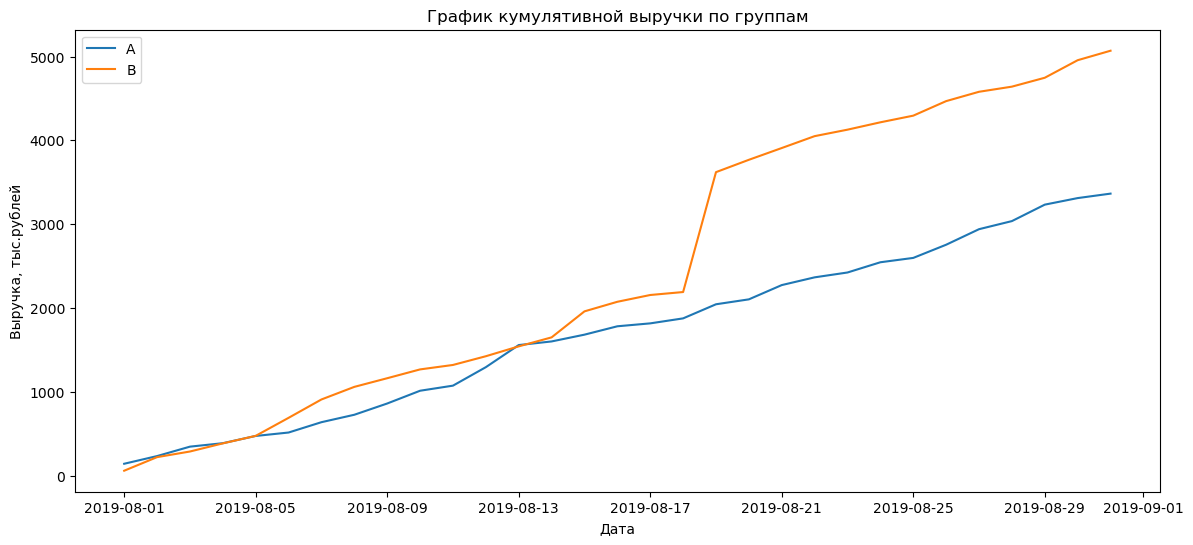

In [38]:
plt.figure(figsize=(14,6))

# Строим график выручки группы А
plt.plot(data['date'], data['cummulative_revenue_a']/1000, label='A')
# Строим график выручки группы B
plt.plot(data['date'], data['cummulative_revenue_b']/1000, label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка, тыс.рублей')
plt.legend()
plt.show()

Выручка растет по обоим группам на протяжении всего времени. По группе **В** 19 августа был совершен заказ на очень крупную сумму, и группа вырвалась вперед, далее графики шли паралельно.

<a id='3.2-bullet'></a>
### График кумулятивного среднего чека по группам

Построим график кумулятивного среднего чека по группам.

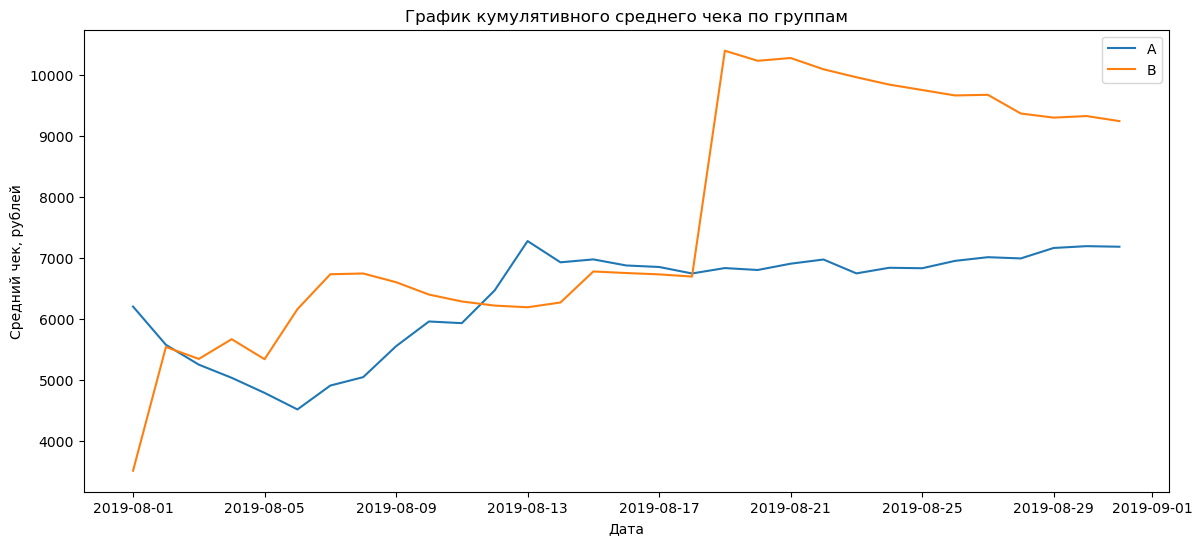

In [39]:
#строим график
plt.figure(figsize=(14,6))
plt.plot(data['date'], data['cummulative_revenue_a']/data['cummulative_orders_a'], label='A')
plt.plot(data['date'], data['cummulative_revenue_b']/data['cummulative_orders_b'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек, рублей')
plt.legend()
plt.show()

По группе **В** видим всплекс среднего чека, связан с заказом 19 августа на сумму 1294500, и далее идет снижение среднего чека по группе **В**. По группе А средний чек стабилизируется у отметки 7500 рублей.

<a id='3.3-bullet'></a>
### График относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

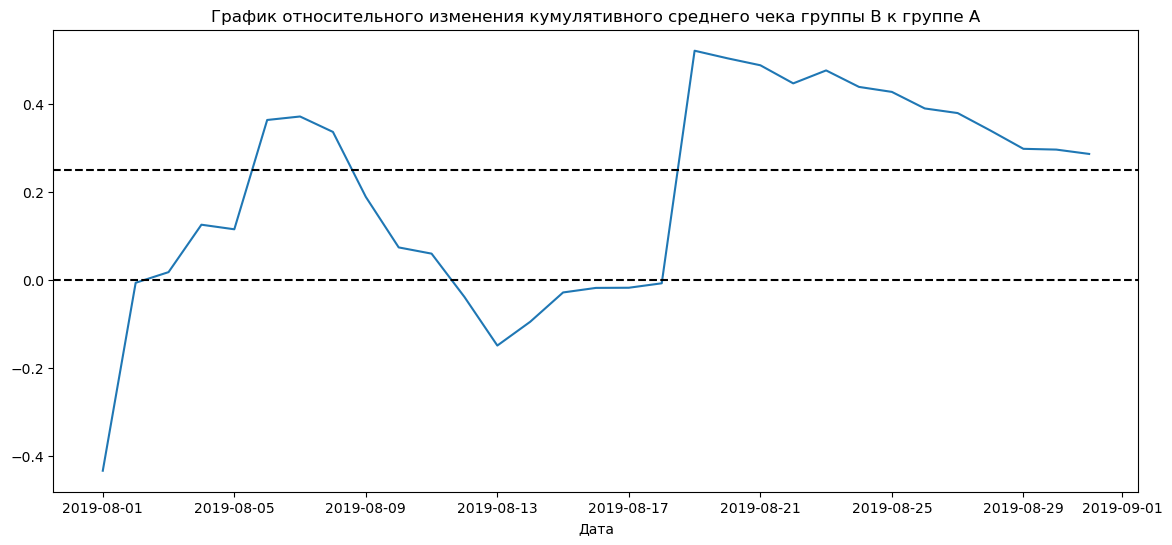

In [40]:
# cтроим отношение средних чеков
plt.figure(figsize=(14,6))
plt.plot(
    data['date'], 
    (data['cummulative_revenue_b']/data['cummulative_orders_b']) / 
    (data['cummulative_revenue_a']/data['cummulative_orders_a']) - 1)
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.25, color='black', linestyle='--');

В нескольких точках график резко скачет, свидетельствует о том, что там спрятались крупные заказы.Средний чек к концу исследования на 25% выше, чем в группе А.

<a id='3.4-bullet'></a>
### График кумулятивного среднего количества заказов на посетителя по группам

Построим график кумулятивного среднего количества заказов на посетителя по группам.

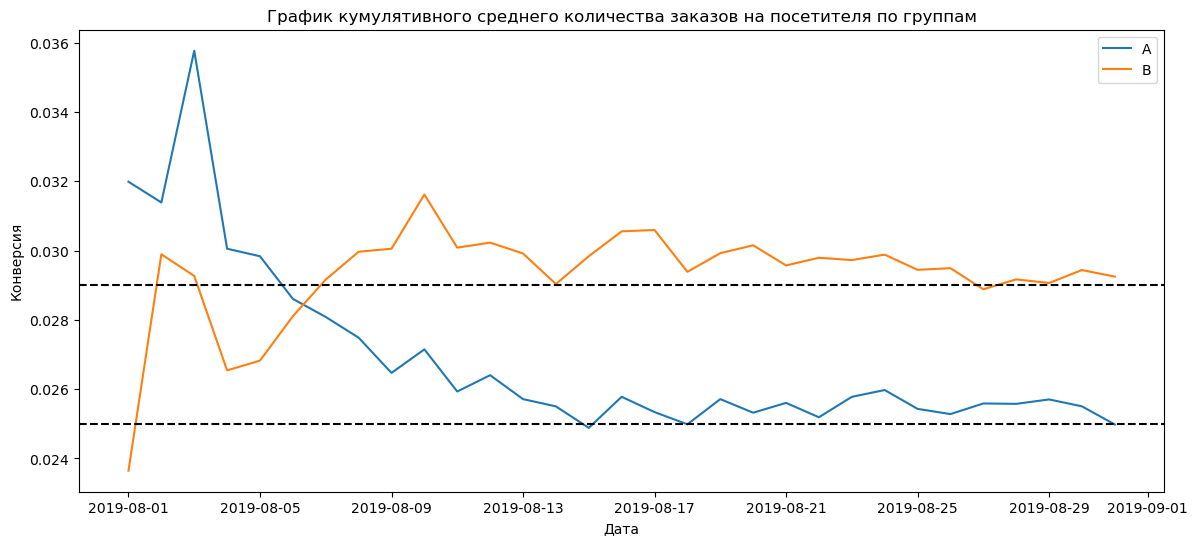

In [41]:
# строим графики
plt.figure(figsize=(14,6))
plt.plot(data['date'], data['cummulative_orders_a']/data['cummulative_visitors_a'], label='A')
plt.plot(data['date'], data['cummulative_orders_b']/data['cummulative_visitors_b'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.axhline(y=0.029, color='black', linestyle='--')
plt.axhline(y=0.025, color='black', linestyle='--');
plt.show()

У группы **В** конверсия из посетилей в заказы выше, чему группы **А** на 0.4%.

<a id='3.5-bullet'></a>
### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

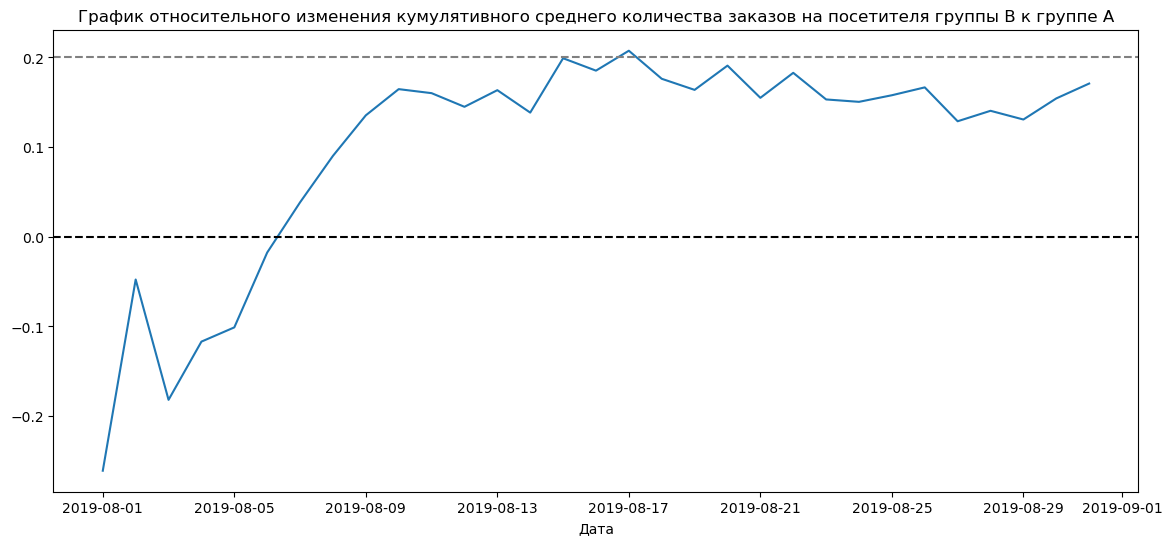

In [42]:
# строим график
plt.figure(figsize=(14,6))
plt.plot(data['date'], 
         (data['cummulative_orders_b']/data['cummulative_visitors_b'])/
         (data['cummulative_orders_a']/data['cummulative_visitors_a'])-1)
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.show();

Группа **В** в начале теста вырвалась вперед по конверсии из посетителей в заказы, затем было небольшое понижением ближе к концу теста и в конце теста снова наметилась тенденция к росту.

<a id='3.6-bullet'></a>
### Точечный график количества заказов по пользователям

Построим точечный график количества заказов по пользователям.

In [43]:
# сгруппируем заказы по пользователям
orders_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique', 'group': 'max'})
)
orders_users.columns = ['visitor_id', 'orders', 'group']
orders_users.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders,group
908,3967698036,3,A
55,249864742,3,B
478,2108163459,3,A
687,2988190573,3,A
890,3908431265,3,A
138,611059232,3,A
632,2742574263,3,B
157,678354126,2,A
323,1404560065,2,B
452,1985475298,2,B


In [44]:
orders_users['orders'].describe() # статистика по количеству заказов

count    973.000000
mean       1.044193
std        0.238090
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: orders, dtype: float64

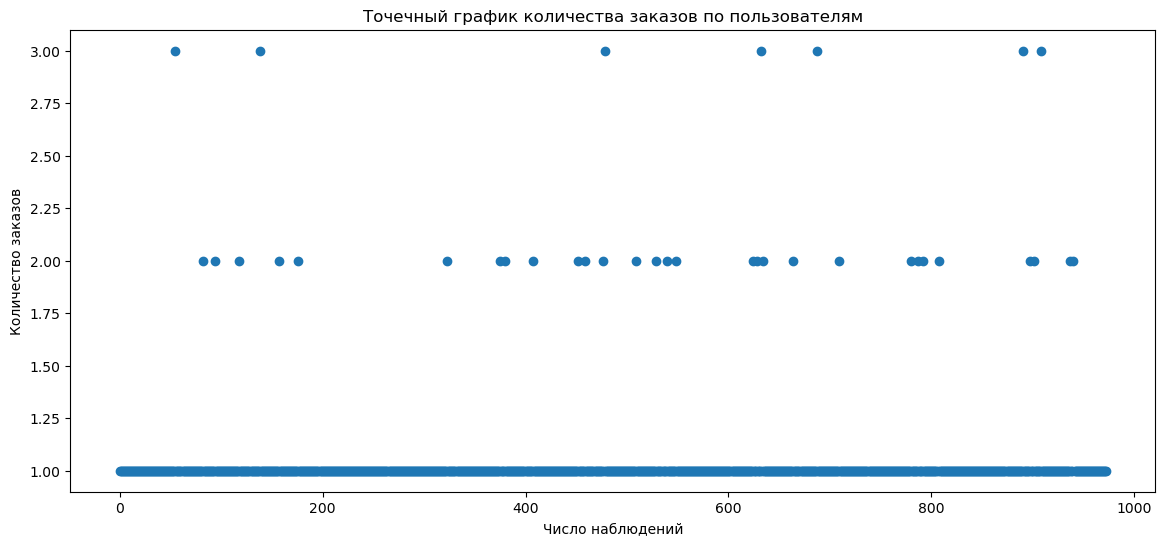

In [45]:
# серия из чисел от 0 до количества наблюдений в orders_users
x_values = pd.Series(range(0, len(orders_users)))
plt.figure(figsize=(14,6))
plt.scatter(x_values, orders_users['orders'])
plt.xlabel('Число наблюдений')
plt.ylabel('Количество заказов')
plt.title('Точечный график количества заказов по пользователям')
plt.show;

Большинство пользователей делали не более 2 заказов. Среднее и медиана 1 заказ на пользователя.

<a id='3.7-bullet'></a>
### Выбор границы для определения аномальных пользователей

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [46]:
print(np.percentile(orders_users['orders'], [95, 99]))

[1. 2.]


99% пользователей делали не более 2 заказов. Выберем 2 заказа как границу, выше будем считать как аномальные значения.

<a id='3.8-bullet'></a>
### Точечный график стоимостей заказов

Построим точечный график стоимостей заказов.

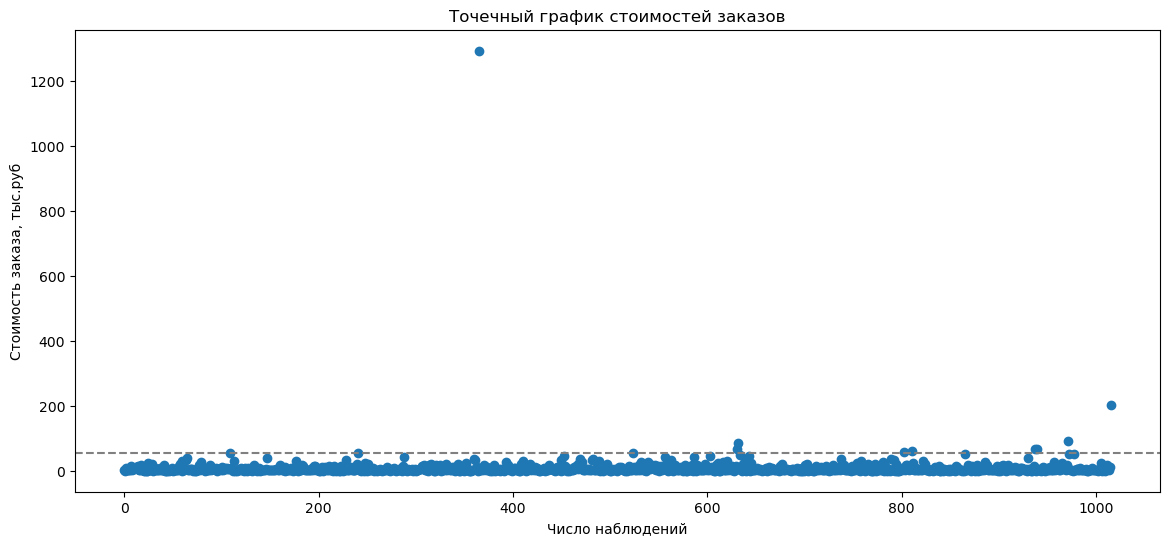

In [47]:
x_values = pd.Series(range(0, len(orders['revenue']/1000)))
plt.figure(figsize=(14,6))
plt.scatter(x_values, orders['revenue']/1000)
plt.xlabel('Число наблюдений')
plt.ylabel('Стоимость заказа, тыс.руб')
plt.title('Точечный график стоимостей заказов')
plt.axhline(y=54, color='grey', linestyle='--')
plt.show();

Большинсво заказов не более 54 тыс.рублей.

<a id='3.9-bullet'></a>
### Выбор границы для определения аномальных заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [48]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


99% стоимости заказов не превышают 53904 тыс.рублей. Выберем эту стоимость как границу, выше будем считать как аномальные значения.

<a id='3.10-bullet'></a>
### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

Создадим переменные orders_users_a и orders_users_b со столбцами ['visitor_id', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов

In [49]:
# выделили пользователей, которые совершили хотя бы 1 заказ в группе А
orders_users_a = orders_users[orders_users['group'] == 'A'][['visitor_id', 'orders']]
orders_users_a

,visitor_id,orders
2,11685486,1
6,54447517,1
8,66685450,1
11,78758296,1
12,85103373,1
...,...,...
960,4227830084,1
963,4237561104,1
964,4243832526,1
968,4259830713,1


In [50]:
# выделили пользователей, которые совершили хотя бы 1 заказ в группе В
orders_users_b = orders_users[orders_users['group'] == 'B'][['visitor_id', 'orders']]
orders_users_b

,visitor_id,orders
0,5114589,1
1,6958315,1
3,39475350,1
4,47206413,1
5,48147722,1
...,...,...
966,4251115836,1
967,4258103007,1
970,4279090005,1
971,4281247801,1


Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни

In [51]:
sample_a = pd.concat(
    [orders_users_a['orders'],
     pd.Series(0, index=np.arange(data['sum_visitors_a'].sum() - len(orders_users_a['orders'])), 
               name='orders')], axis=0)
sample_a.head()

2     1
6     1
8     1
11    1
12    1
Name: orders, dtype: int64

In [52]:
sample_b = pd.concat(
    [orders_users_b['orders'],
     pd.Series(0, index=np.arange(data['sum_visitors_b'].sum() - len(orders_users_b['orders'])), 
                name='orders')],axis=0)
sample_b.head()

0    1
1    1
3    1
4    1
5    1
Name: orders, dtype: int64

In [53]:
#Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой
print("p-value - {0:.3f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))

p-value - 0.007


In [54]:
#Выведем относительный прирост среднего числа заказов группы B: 
# среднее число заказов группы B / среднее число заказов группы A - 1.  Округлим до трёх знаков после запятой.
print("Относительный прирост среднего числа заказов группы B - {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

Относительный прирост среднего числа заказов группы B - 0.171


По «сырым» данным есть различия в среднем числе заказов групп A и B. 
P-value = 0.007 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выйгрыш группы B равен 17.1%.

<a id='3.11-bullet'></a>
### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 

In [55]:
#Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой
print('P-value-{0:.3f}'.format(
    st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                    orders[orders['group']=='B']['revenue'])[1]))


P-value-0.829


In [56]:
# относительные различия в среднем чеке между группами
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A на 28.7%. Может быть связан с аномально большим заказом.

<a id='3.12-bullet'></a>
### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 53904 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и до 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — users_many_orders и пользователей, совершивших заказы дороже 53904 — users_expensive_orders. Объединим их в таблице abnormal_users. 
Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [57]:
# пользователи с числом заказов болеше 99 процентиля
users_many_orders = pd.concat(
    [
        orders_users_a[orders_users_a['orders'] > 2]['visitor_id'],
        orders_users_b[orders_users_b['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
users_many_orders.head()

138     611059232
478    2108163459
687    2988190573
890    3908431265
908    3967698036
Name: visitor_id, dtype: int64

In [58]:
# пользователи с суммой заказа больше 99 процентиля
users_expensive_orders = orders[orders['revenue'] > 53904]['visitor_id']
users_expensive_orders.head()

425    1920142716
743    4133034833
744     888512513
940    4003628586
949     887908475
Name: visitor_id, dtype: int64

In [59]:
# список аномальных пользователей
abnormal_users = (
    pd.concat([users_many_orders, users_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users.head()

1099    148427295
55      249864742
138     611059232
949     887908475
744     888512513
Name: visitor_id, dtype: int64

In [60]:
#аномальные пользователи - количество
abnormal_users.shape[0]

16

In [61]:
# пользователи из группы А по фильтрованным данным
sample_filtered_a = pd.concat(
    [orders_users_a[np.logical_not(orders_users_a['visitor_id'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(data['sum_visitors_a'].sum() - len(orders_users_a['orders'])), name='orders')],
    axis=0,
)
sample_filtered_a.head()

2     1
6     1
8     1
11    1
12    1
Name: orders, dtype: int64

In [62]:
# пользователи из группы В по фильрованным данным
sample_filtered_b = pd.concat(
    [orders_users_b[np.logical_not(orders_users_b['visitor_id'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(data['sum_visitors_b'].sum() - len(orders_users_b['orders'])),name='orders')],
    axis=0,
)
sample_filtered_b.head()

0    1
1    1
3    1
4    1
5    1
Name: orders, dtype: int64

In [63]:
#Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой
print('P-value - {0:.3f}'.format(st.mannwhitneyu(sample_filtered_a, sample_filtered_b)[1]))
 

P-value - 0.004


In [64]:
print('Относительный прирост среднего числа заказов группы B - {0:.3f}'.format(
    sample_filtered_b.mean()/sample_filtered_a.mean()-1))

Относительный прирост среднего числа заказов группы B - 0.201


По «очищенным» данным также есть различия в среднем числе заказов групп A и B. 
P-value = 0.013 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выйгрыш группы B равен 20.1% - выше чем по сырым данным.

<a id=3.13-bullet></a>
### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [65]:
print('P-value - {0:.3f}'.format(
    st.mannwhitneyu(
        orders[np.logical_and(orders['group'] == 'A', 
               np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
        orders[np.logical_and(orders['group'] == 'B', 
               np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
        )[1]
    )
)

P-value - 0.788


In [66]:
# относительные различия в среднем чеке между группами
print("{0:.3f}".format(
    orders[np.logical_and(orders['group'] == 'B',
           np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',
           np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )]['revenue'].mean() - 1
    )
)

-0.032


P-value немного ниже чем в сырых данных и также значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако, средний чек группы B по очищенным данным стал ниже среднего чека группы A на 3.2%.

<a id='3.14-bullet'></a>
### Решение по результатам теста

Имеющиеся факты:

- Есть статистически значимое различие по среднему количеству заказов между группами по «сырым», и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A:
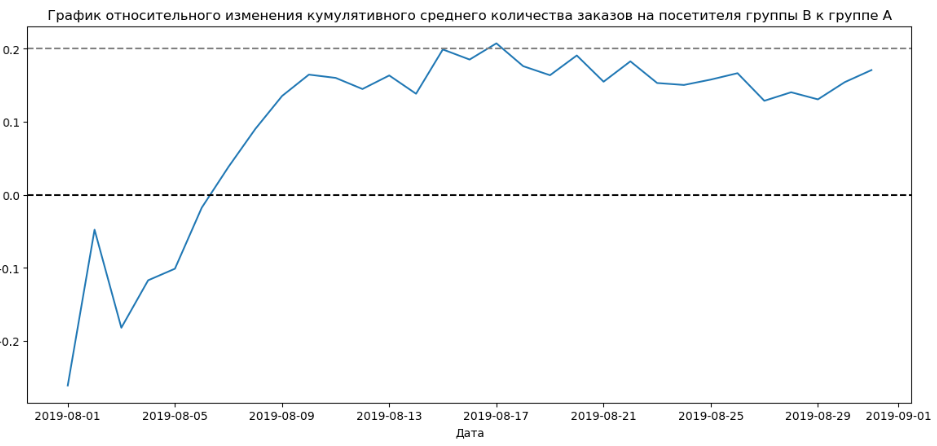
- График различия среднего чека говорит о том, что результаты группы B на 25% лучше
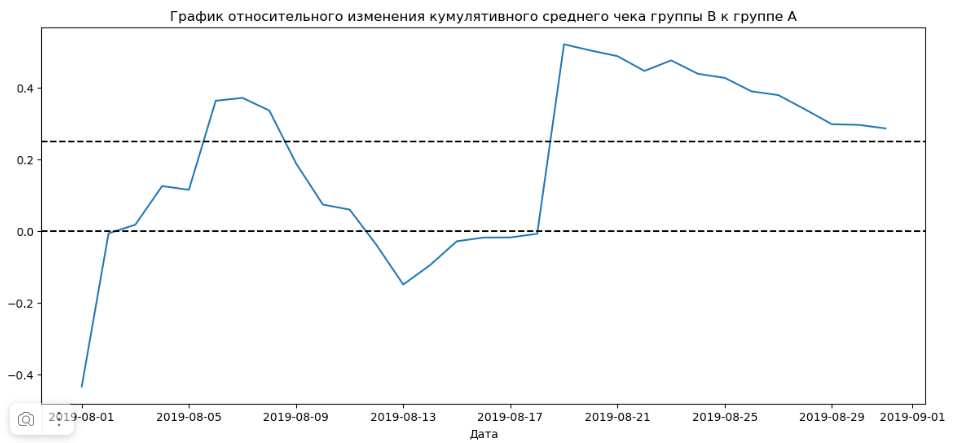

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным, несмотря на то, что средний чек по обоим группам, при исключении аномалий почти совпадает. Конверсия из посетилей в заказы у группы В лучше чем у группы А.

<a id='4-bullet'></a>
## ВЫВОД

При проведении исследования были получены данные крупного интернет-магазина. Совместно с отделом маркетинга были подготовлены гипотезы для увеличения выручки интернет-магазина. Была поставлена задача приотизировать гипотезы, запустить A/B-тест и проанализируйть результаты.

В полученных датафреймах провели предобработку данных: заменили названия столбцов, преобразовали данные в нужный тип данных, проверили дубликаты и отсутствие пропусков. Обработали аномалии.

При приоритизации гипотез применили фреймворки ICE и RICE - победила гипотеза №7, была в топах в обоих фреймворках.

По данным А/В теста  построили графики: кумулятивной выручки и кумулятивного среднего чека по группам, график относительного изменения кумулятивного среднего чека и кумулятивного среднего количества заказов на посетителя группы B к группе A. Построили точечные графики количества и суммы заказов. Посчитали 95-й и 99-й перцентили количества и суммы заказов, выбрали границу для определения аномальных значений.

Исходя из посчитанной статистической значимости различий в среднем количестве заказов на посетителя и в среднем чеке заказа между группами по сырым и очищенным данным определили, что есть различия в группе В по отношению к группе А - конверсия из посетителей в заказы лучше, между тем средний чек не сильно отличается между группами.

А/В тест можно приостановить и признать успешным, при лучшей конверсии и том же среднем чеке интернет-магазин может увелить выручку.
